In [268]:
import sys
import os
import h5py
import numpy as np
import copy
from scipy import signal
import matplotlib.pyplot as plt

# Parameters

In [131]:
PMTS_PER_MPMT = 19
BARREL_MAP_ARRAY_IDXS = [6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 15, 16, 17, 12, 13, 14, 18]
MPMT_POSITIONS = np.load('/data/WatChMaL/data/IWCDshort_mPMT_image_positions.npz')['mpmt_image_positions']
DATA_SIZE = np.insert(np.max(MPMT_POSITIONS, axis=0) + 1, 0, PMTS_PER_MPMT)

# Import Files

In [9]:
h5_truehits = h5py.File("/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_truehits.h5","r")
h5_digihits = h5py.File("/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_digihits.h5","r")

In [156]:
print(f"True hits: {h5_truehits.keys()}")
print(f"Digi hits: {h5_digihits.keys()}")

True hits: <KeysViewHDF5 ['angles', 'energies', 'event_hits_index', 'event_ids', 'hit_parent', 'hit_pmt', 'hit_time', 'labels', 'positions', 'root_files', 'veto', 'veto2']>
Digi hits: <KeysViewHDF5 ['angles', 'energies', 'event_hits_index', 'event_ids', 'hit_charge', 'hit_pmt', 'hit_time', 'labels', 'positions', 'root_files', 'veto', 'veto2']>


In [162]:
h5_truehits["hit_time"]

<HDF5 dataset "hit_time": shape (11865355642,), type "<f4">

# Manipulating data

In [437]:
'''
Get data from event - pass in event_id and h5 file (digitised/truehits)
adapted from https://github.com/Whisky-Jack/WatChMaL_analysis/blob/main/short_tank_exploratory_data_analysis/new_dataset/3.%20dataset_analysis%20I.ipynb
'''
def get_event_data_from_index(item, h5):
    
    idxs = np.where(h5["event_ids"][:] == item)[0]
    if idxs.any():
        idx = idxs[0]
    else:
        raise LookupError("event_id does not exist")
        return
        
    start = h5["event_hits_index"][idx]
    stop  = h5["event_hits_index"][idx + 1]
    
    hit_pmts = h5["hit_pmt"][start:stop].astype(np.int16)
    if "hit_charge" in h5.keys(): # Digitised hits
        hit_charges = h5["hit_charge"][start:stop]
    else: # True hits - count number of occurrences of each pmt hit, remove duplicates in hit_pmt
        hit_pmts, hit_charges = np.unique(hit_pmts, return_counts = True)

    hit_mpmts = hit_pmts // PMTS_PER_MPMT
    hit_pmt_in_modules = hit_pmts % PMTS_PER_MPMT

    hit_rows = MPMT_POSITIONS[hit_mpmts, 0]
    hit_cols = MPMT_POSITIONS[hit_mpmts, 1]

    sample_data = np.zeros(DATA_SIZE)
    sample_data[hit_pmt_in_modules, hit_rows, hit_cols] = hit_charges

    # fix barrel array indexing to match endcaps in xyz ordering
    sample_data[:, 12:28, :] = sample_data[BARREL_MAP_ARRAY_IDXS, 12:28, :]
    moved_data = np.moveaxis(sample_data, 0, -1)
    return moved_data

In [382]:
# Test event
event_idx = 236

test_data_truehits = get_event_data_from_index(event_idx, h5_truehits)
test_data_digihits = get_event_data_from_index(event_idx, h5_digihits)

print(test_data_truehits.shape)
print(test_data_digihits.shape)

(29, 40, 19)
(29, 40, 19)


# Plotting

In [315]:
sys.path.append('../utils')
from plot_utils import get_plot_array
from matplotlib import cm

In [435]:
def plot_event(truehits, digihits, idx = None):
    summed_event_data_truehits = np.sum(test_data_truehits, axis=-1)
    summed_event_data_digihits = np.sum(test_data_digihits, axis=-1)

    fig, ax = plt.subplots(1, 2, figsize=(32, 20),facecolor='w')
    ax[0].imshow(summed_event_data_truehits, cmap='jet', origin='lower')
    ax[0].set_title('True hits, charge sum in mPMT', fontsize=30)
    ax[1].imshow(summed_event_data_digihits, cmap='jet', origin='lower')
    ax[1].set_title('Digitised hits, charge sum in mPMT', fontsize=30)
    
    if idx: # event index, optional parameter
        fig.suptitle(f"Event No. {idx}", fontsize = 40)
        
    plt.tight_layout()
    plt.show()

    event_data_array_truehits = get_plot_array(test_data_truehits)
    print(np.sum(event_data_array_truehits > 0))
    event_data_array_truehits = np.ma.masked_where(event_data_array_truehits < 0.05, event_data_array_truehits)
    event_data_array_digihits = get_plot_array(test_data_digihits)
    event_data_array_digihits = np.ma.masked_where(event_data_array_digihits < 0.05, event_data_array_digihits)

    fig, ax = plt.subplots(2, 1, figsize=(32, 20),facecolor='w')
    ax[0].imshow(event_data_array_truehits, origin="upper", cmap="viridis")
    ax[0].set_title('True hits, charge in mPMT', fontsize=20)
    ax[1].imshow(event_data_array_digihits, origin="upper", cmap="viridis")
    ax[1].set_title('Digitised hits, charge in mPMT', fontsize=20)

    plt.show()

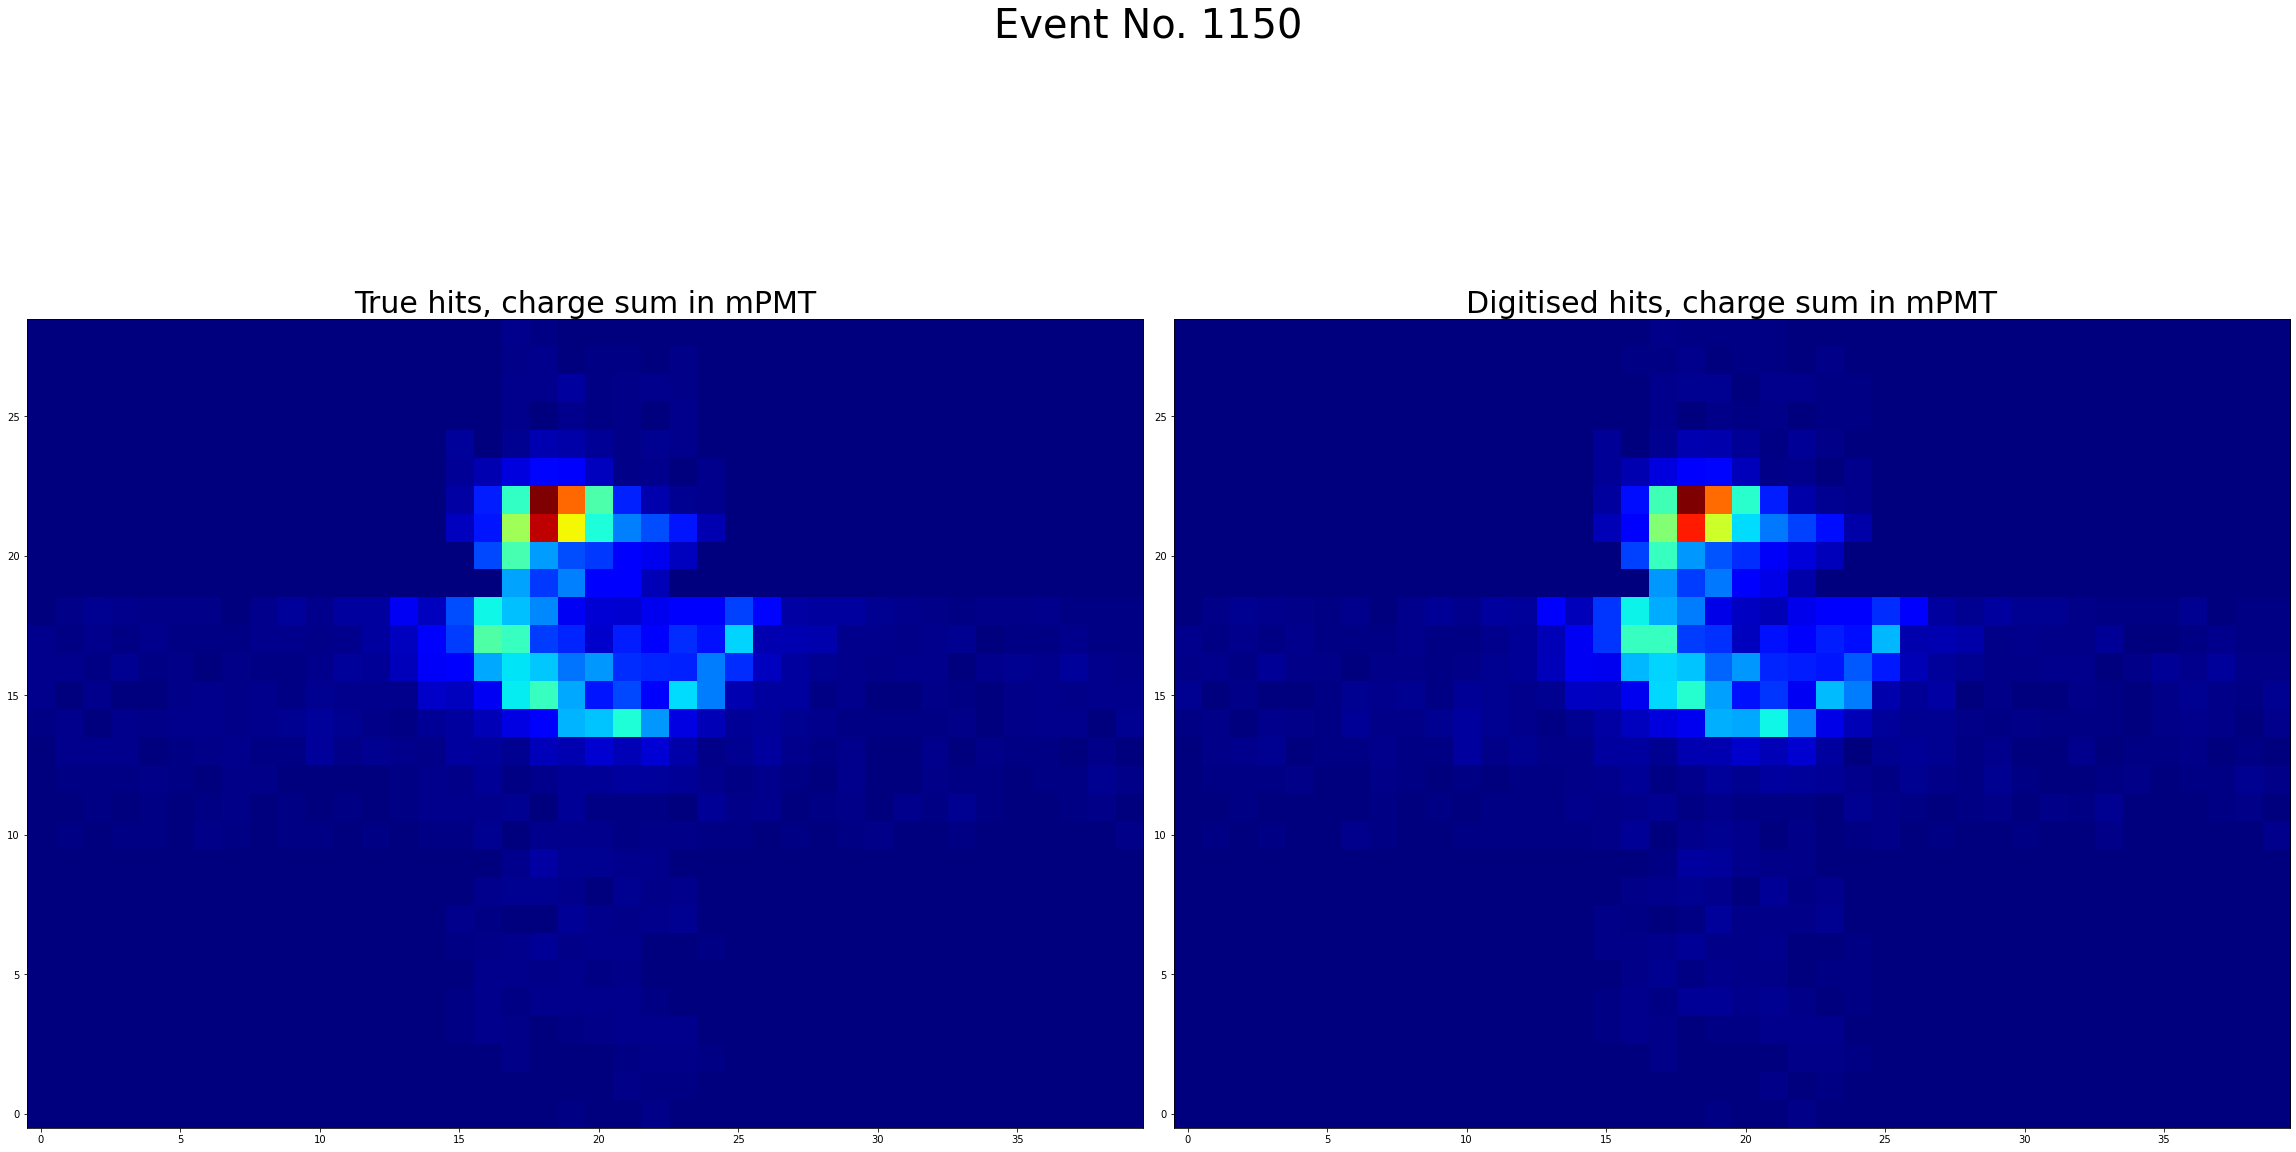

2810


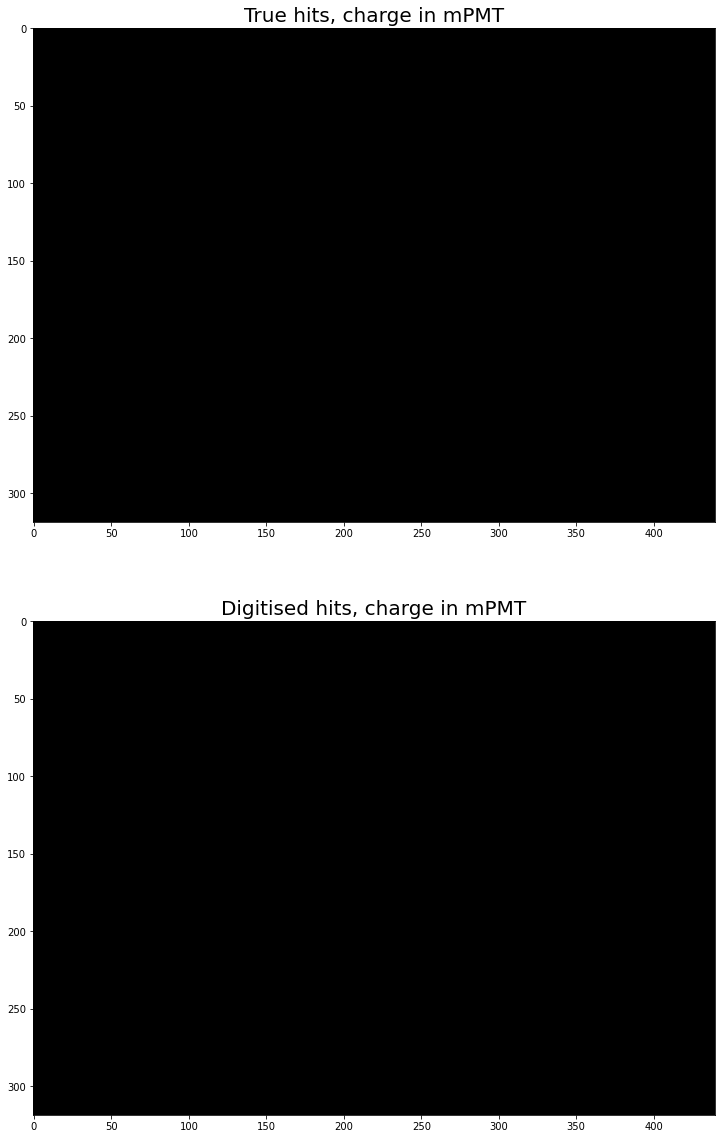

In [442]:
# Tested: 

event_idx = 1150

try:
    test_data_truehits = get_event_data_from_index(event_idx, h5_truehits)
    test_data_digihits = get_event_data_from_index(event_idx, h5_digihits)
    plot_event(test_data_truehits,test_data_digihits, event_idx)
except LookupError:
    print(f"event_ind {event_idx} not found in one or both files")